In [1]:
# loading virtual python environment (created in EC2 terminal)
!source ./bin/activate

In [18]:
# import python libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb 
from sklearn.model_selection import train_test_split # split into training and testing
from sklearn.ensemble import RandomForestRegressor # for regressions
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# read in data from github raw
in_df = pd.read_csv("https://delvex-software-center.s3.ap-south-1.amazonaws.com/USGS/all_month.csv")

In [4]:
in_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9593 entries, 0 to 9592
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9593 non-null   object 
 1   latitude         9593 non-null   float64
 2   longitude        9593 non-null   float64
 3   depth            9593 non-null   float64
 4   mag              9592 non-null   float64
 5   magType          9592 non-null   object 
 6   nst              8018 non-null   float64
 7   gap              8018 non-null   float64
 8   dmin             8017 non-null   float64
 9   rms              9592 non-null   float64
 10  net              9593 non-null   object 
 11  id               9593 non-null   object 
 12  updated          9593 non-null   object 
 13  place            9593 non-null   object 
 14  type             9593 non-null   object 
 15  horizontalError  7317 non-null   float64
 16  depthError       9592 non-null   float64
 17  magError      

In [5]:
in_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-04-03T03:16:50.230Z,38.840668,-122.834335,1.32,0.53,md,6.0,122.0,0.002262,0.01,...,2025-04-03T03:18:28.928Z,"10 km NNW of The Geysers, CA",earthquake,0.61,1.23,0.310,9.0,automatic,nc,nc
1,2025-04-03T03:08:03.540Z,61.556800,-141.271600,13.40,1.20,ml,NaN,NaN,NaN,0.20,...,2025-04-03T03:10:11.692Z,"88 km E of McCarthy, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
2,2025-04-03T02:59:56.724Z,61.789200,-149.608200,38.70,1.20,ml,NaN,NaN,NaN,0.53,...,2025-04-03T03:01:20.110Z,"18 km N of Meadow Lakes, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak
3,2025-04-03T02:54:35.248Z,60.081400,-152.528700,97.80,1.40,ml,NaN,NaN,NaN,0.46,...,2025-04-03T02:57:27.690Z,"46 km WNW of Happy Valley, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
4,2025-04-03T02:41:42.280Z,35.639833,-117.548500,8.08,0.89,ml,19.0,63.0,0.092800,0.13,...,2025-04-03T02:45:07.322Z,"12 km E of Ridgecrest, CA",earthquake,0.21,0.86,0.161,16.0,automatic,ci,ci


In [6]:
# separating data into input and output for regression
# .values makes in an npy array
features = ['latitude', 'longitude', 'depth']
label = 'mag'

In [7]:
in_df = in_df.dropna(subset = [label]) # drop an na from labels

In [8]:
# doing in features - fill in NA 
for col in features:
    in_df[col] = in_df[col].fillna(in_df[col].median())

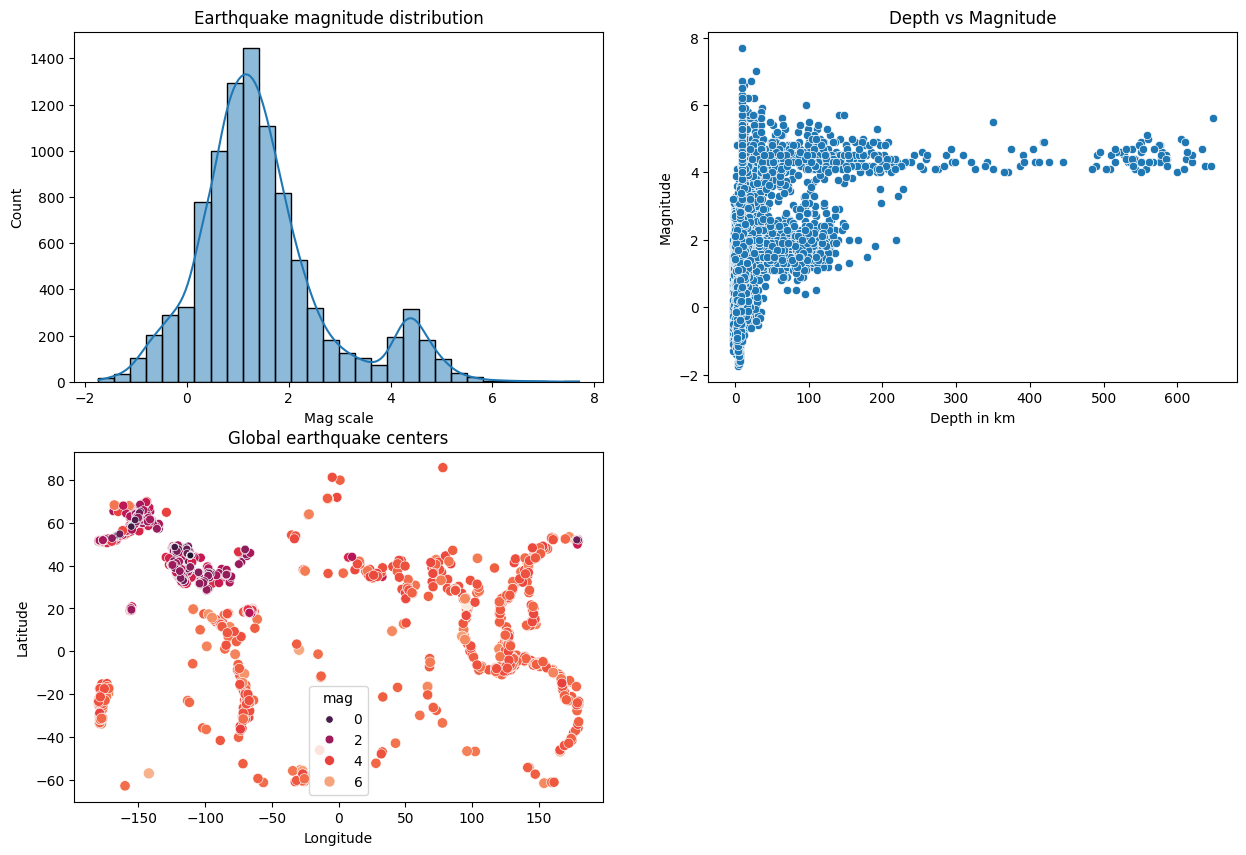

In [10]:
# some basic visuals for data analysis
plt.figure(figsize= (15,10))

# first plot
plt.subplot(2,2,1) # 2 row, 2 col, 1st plot 
plt.title("Earthquake magnitude distribution")
plt.xlabel("Mag scale")
sb.histplot(in_df[label], kde = True, bins=30)
# second plot 
plt.subplot(2,2,2) # 2 row, 2 col, 2nd plot 
plt.title("Depth vs Magnitude")
plt.xlabel("Depth in km")
plt.ylabel("Magnitude")
sb.scatterplot(x = 'depth', y = label, data= in_df)
#sb.scatterplot(x = 'depth', y = 'mag', data= in_df)
# thrid plot  - Globe locations 
plt.subplot(2,2,3) # 2 row, 2 col, 2nd plot 
plt.title("Global earthquake centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
sb.scatterplot(x = 'longitude', y = 'latitude', size = label, data= in_df, hue='mag', palette='rocket')

plt.show()

In [11]:
# reconsidering features and labels 

feature_data = in_df[features]
label_data = in_df[label]
feature_data


,latitude,longitude,depth
0,38.840668,-122.834335,1.32
1,61.556800,-141.271600,13.40
2,61.789200,-149.608200,38.70
3,60.081400,-152.528700,97.80
4,35.639833,-117.548500,8.08
...,...,...,...
9588,44.739000,-111.123333,7.15
9589,37.428500,-119.018500,3.69
9590,44.726000,-111.120667,2.38
9591,-57.288500,147.327500,10.00


In [12]:
label_data

0       0.53
1       1.20
2       1.20
3       1.40
4       0.89
        ... 
9588   -0.37
9589    1.70
9590   -0.92
9591    4.50
9592    1.44
Name: mag, Length: 9592, dtype: float64

In [13]:
# split into training and testing dfeature_data
# assign into 4 variables on left side of =
training_ft, testing_ft, training_lb, testing_lb = train_test_split(feature_data, label_data, test_size=0.2, random_state=100) # 0.2 means 20% goes to testing, 80% is used for training. set same # to get same splits


In [14]:
# calling regression model 
regr_model = RandomForestRegressor()

In [15]:
# training model 
trained_model = regr_model.fit(training_ft, training_lb)

In [16]:
# predicting magnitude 
print("actual Mag : values ", testing_lb)

actual Mag : values  8646    1.03
995     1.38
553     0.20
4322    2.10
2589    0.58
        ... 
5284    1.50
6501    1.83
6448    1.40
64      0.80
1501    1.12
Name: mag, Length: 1919, dtype: float64


In [17]:
predicted_mag = trained_model.predict(testing_ft)
print(predicted_mag)

[1.0033 1.4973 0.0465 ... 1.6486 1.224  0.8427]


In [19]:
# doing model evluation using MSE 
error = mean_squared_error(testing_lb, predicted_mag)
print("error ", error)

error  0.2392571717664097


In [21]:
# 
print(f"Model MSE : {error:.4f}")

Model MSE : 0.2393


In [22]:
rsq = r2_score(testing_lb, predicted_mag)
print("r-squared = ", rsq)

r-squared =  0.8492614760058248


In [23]:
mae = mean_absolute_error(testing_lb, predicted_mag)
print("MAE = ", mae)

MAE =  0.3573594233104655
